In [30]:
%matplotlib inline

#-----------------------------------------------------------
import os
import math
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from matplotlib import cm        # module palettes de couleurs
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
#-----------------------------------------------------------
#np.set_printoptions(edgeitems=10)
np.set_printoptions(linewidth = 220)
np.set_printoptions(precision=4)
#np.set_printoptions(precision=3,formatter={'float': '{:9.3f}'.format})
pd.set_option('precision', 5)
pd.set_option("display.max_columns",20)
pd.set_option('display.max_rows', 999)
#pd.set_option('max_colwidth', 6)


## Chargement des données

Regardons d'abord les 2 bases de données que l'on a à disposition :


*   *'global_data'* : base de données composée de 9000 relevés pour lesquels la concentration en 10 types de pigments a été mesurée
*   *'tara_data'* : base de données de 211 relevés pour lesquels les mêmes concentrations sont mesurées, auxquelles s'ajoutent le pourcentage de 7 groupe de phytoplanctons dans l'échantillon.






In [2]:
# 9000 lignes x 10 pigments
# global_data = pd.read_excel('Data_Etude_de_Cas.xlsx',sheet_name='Global HPLC Data')
df_global_data = pd.read_excel('Data_Etude_de_Cas.xlsx',sheet_name='Global HPLC Data',usecols = 'F:O') #global data sans les colonnes dates

# 210 lignes x (10 pigments + 7 % de phytoplanctons)
df_tara_data = pd.read_excel('Data_Etude_de_Cas.xlsx',sheet_name='Tara Data Phyto + HPLC',usecols = 'G:W')


In [3]:
df_global_data.head()

,"Chlorophyll a, total",Divinyl chlorophyll a,Chlorophyll b,Divinyl chlorophyll b,19-Hexanoyloxyfucoxanthin,19-Butanoyloxyfucoxanthin,Fucoxanthin,Peridinin,Alloxanthin,Zeaxanthin
0,0.482,0.055,0.059,NaN,0.085,0.016,0.029,0.017,0.007,0.188
1,1.248,0.000,0.277,NaN,0.248,0.061,0.332,0.064,0.106,0.039
2,1.517,0.000,0.206,NaN,0.234,0.065,0.636,0.056,0.207,0.030
3,3.363,0.000,0.000,NaN,0.137,0.035,2.057,0.085,0.000,0.048
4,1.325,0.000,0.192,NaN,0.288,0.053,0.336,0.152,0.032,0.174


In [4]:
df_tara_data.head()

,Diatoms,Coccolithophores (Haptophytes),Dinoflagellates,Prochlorococcus,Synechococcus,chlorophytes,other_Haptophytes,"Chlorophyll a, total",Divinyl chlorophyll a,Chlorophyll b,Divinyl chlorophyll b,19-Hexanoyloxyfucoxanthin,19-Butanoyloxyfucoxanthin,Fucoxanthin,Peridinin,Alloxanthin,Zeaxanthin
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.00378,0.01410,0.02332,0.68080,0.15722,0.03385,0.03577,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.01393,0.01678,0.03135,0.19303,0.43812,0.04704,0.12771,0.42017,0.00126,0.03323,0.0,0.02532,0.00388,0.12139,0.0,0.00154,0.00696


# **Etude unidimensionnelle**

## Grande base de données *global_data*

### Caractéristiques unidimensionnelles

In [5]:
df_global_data.describe()

,"Chlorophyll a, total",Divinyl chlorophyll a,Chlorophyll b,Divinyl chlorophyll b,19-Hexanoyloxyfucoxanthin,19-Butanoyloxyfucoxanthin,Fucoxanthin,Peridinin,Alloxanthin,Zeaxanthin
count,9484.00000,3945.00000,8242.00000,2312.00000,9442.00000,9295.00000,9269.00000,8500.00000,8088.00000,8520.00000
mean,1.54416,0.03178,0.05721,0.00295,0.18065,0.04242,0.85459,0.07378,0.06015,0.05247
std,3.68796,0.08862,0.20121,0.01748,0.69556,0.11607,2.98596,0.58111,0.20495,0.14162
min,0.00000,0.00000,0.00000,0.00000,-0.00320,0.00000,-0.00310,0.00000,-0.00290,0.00000
25%,0.15300,0.00000,0.00400,0.00000,0.02477,0.00600,0.01500,0.00000,0.00000,0.00035
50%,0.39189,0.01242,0.01741,0.00000,0.06300,0.01839,0.07946,0.00423,0.00441,0.01853
75%,1.17046,0.04160,0.05470,0.00010,0.13900,0.04500,0.37200,0.02000,0.03590,0.05900
max,92.41320,3.05633,9.12550,0.34100,13.34613,4.61160,100.77410,25.64400,5.45264,2.39130


### Box-plot

In [6]:
  #sns.catplot(data=df_train[['TARGET_FLAG',column]],x='TARGET_FLAG', y=column, kind="box"

### Histogrammes des variables

On s'intéresse d'abord à la répartition des concentrations de chaque pigment pour la grosse base de données *'global_data'*.

In [7]:
pigments = df_global_data.columns
pigments

Index(['Chlorophyll a, total', 'Divinyl chlorophyll a', 'Chlorophyll b',
       'Divinyl chlorophyll b', '19-Hexanoyloxyfucoxanthin',
       '19-Butanoyloxyfucoxanthin', 'Fucoxanthin', 'Peridinin', 'Alloxanthin',
       'Zeaxanthin'],
      dtype='object')

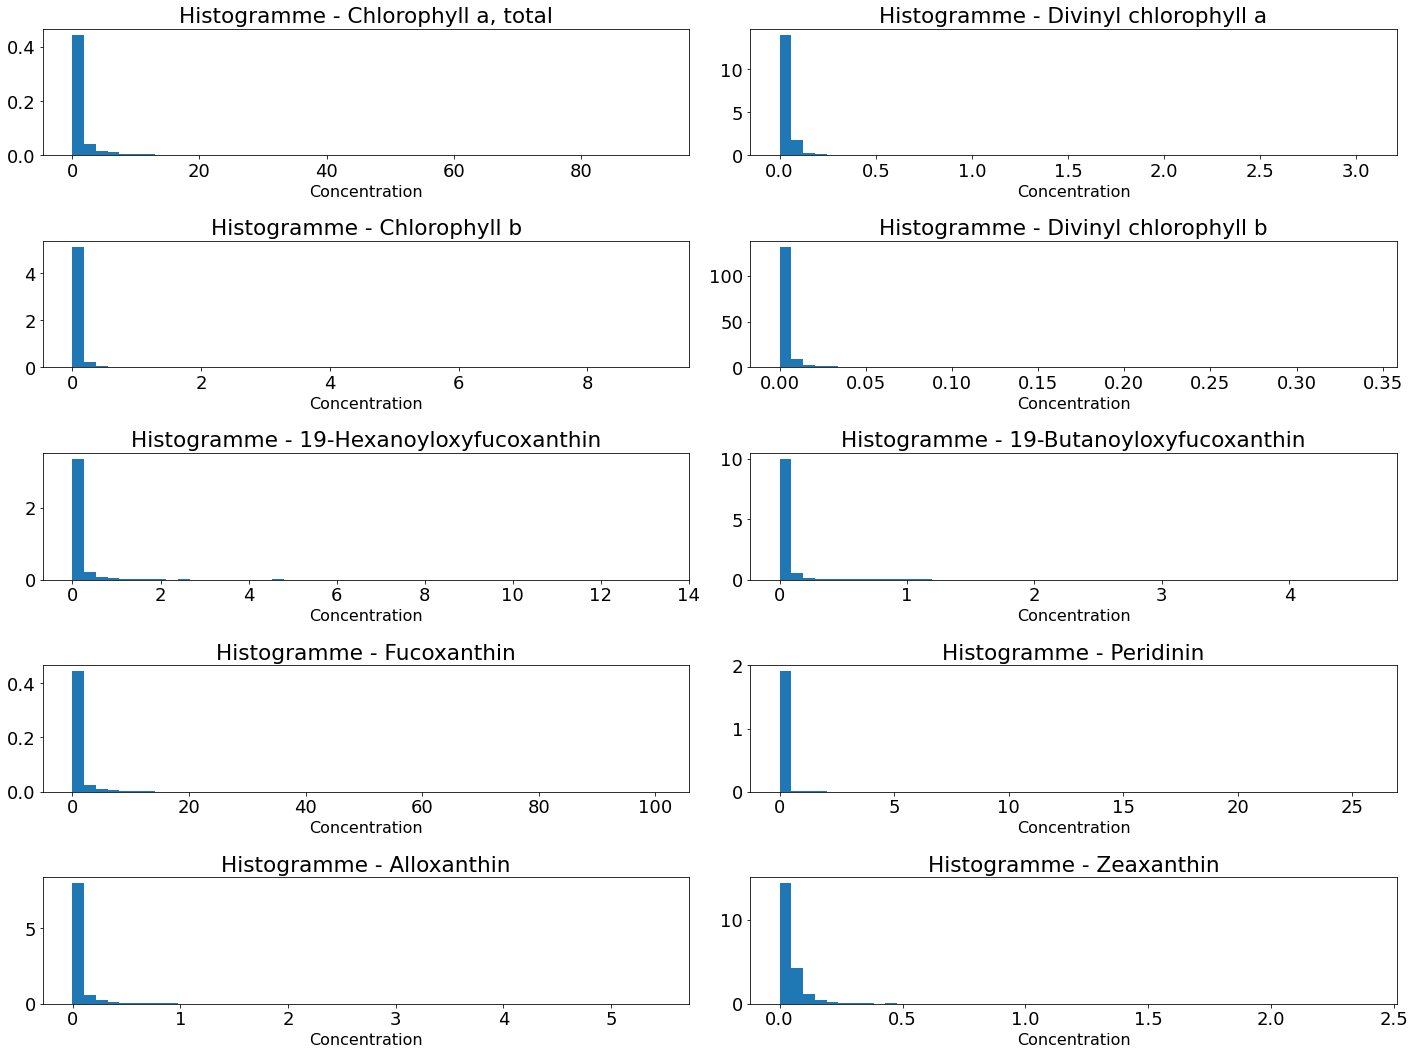

In [8]:

nb_variables = 10
figure = plt.figure(figsize=(20, 15))
nbPlt = nb_variables*(nb_variables-1)/2
nb_c = 2
# nb_l = int(np.ceil(nbPlt/nb_c))
nb_l = 5
cpt=0
for i in range(nb_variables):
        cpt+=1
        ax=plt.subplot(nb_l,nb_c,cpt)
        ax.hist(df_global_data[pigments[i]].values, density=True, bins=50)
        plt.xlabel(f'Concentration',fontsize=16)
        #plt.ylabel(f'{}',fontsize=16)
        plt.title(f"Histogramme - {pigments[i]}")
        plt.tight_layout()
        #plt.xscale('log')

## Base de données *tara_data*

In [9]:
columns_taradata = df_tara_data.columns

# Gestion des valeurs manquantes

Dans cette partie, on va s'intéresser aux données manquantes des tableaux. Celles-ci apparaissent sous la forme *'NaN'*.

## Base de données *global_data*

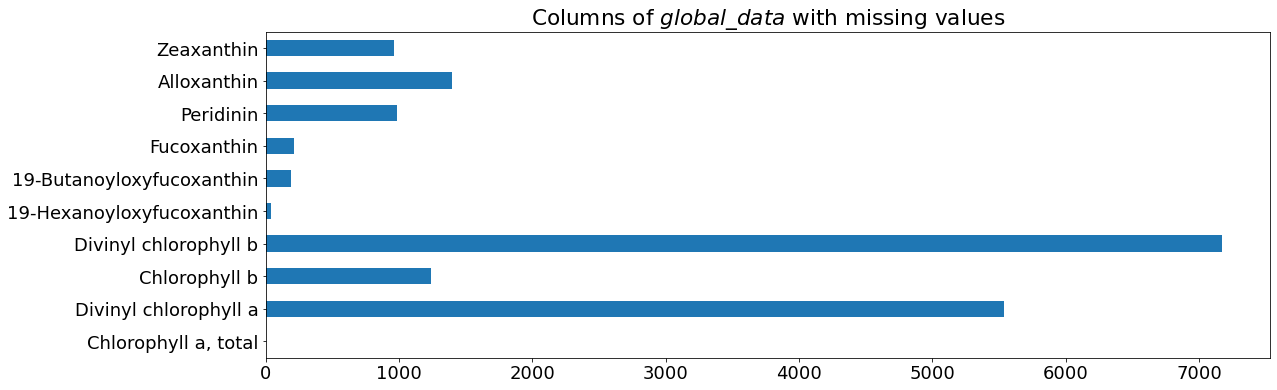

In [10]:
df_global_data.isna().sum().plot.barh()
plt.title('Columns of $global\_data$ with missing values')
plt.show()

On remarque aussi que certaines variables ont une proportion de valeurs NaN considérables. Calculons ce pourcentage.

In [11]:
pctg_nan = np.reshape(np.array(df_global_data.isna().sum()/np.shape(df_global_data)[0]*100),(1,10))
np.around(pctg_nan,2)
df_pctgNaN = pd.DataFrame(pctg_nan,columns = pigments, index = ['% de NaN'])
display(df_pctgNaN)

,"Chlorophyll a, total",Divinyl chlorophyll a,Chlorophyll b,Divinyl chlorophyll b,19-Hexanoyloxyfucoxanthin,19-Butanoyloxyfucoxanthin,Fucoxanthin,Peridinin,Alloxanthin,Zeaxanthin
% de NaN,0.0,58.40363,13.09574,75.6221,0.44285,1.99283,2.26698,10.37537,14.71953,10.16449


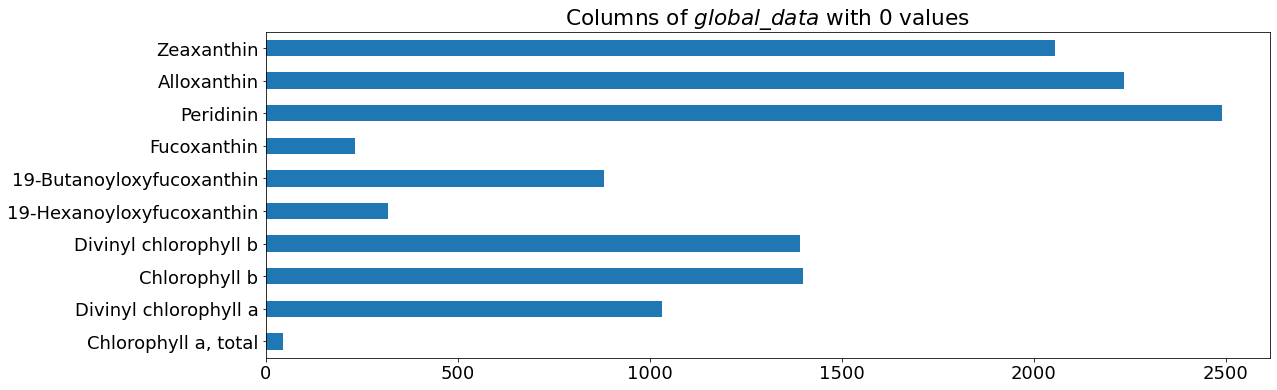

In [12]:
(df_global_data == 0).sum(axis=0).plot.barh()
plt.title('Columns of $global\_data$ with 0 values')
plt.show()

In [13]:
#Vérification NaN != 0 
# Pour cela on vérifie que nb_NaN + nb_0 + reste = nb individus
df_global_data.isna().sum() + (df_global_data == 0).sum(axis=0) + ((df_global_data > 0)).sum(axis=0) #== df_global_data.shape[0]

Chlorophyll a, total         9484
Divinyl chlorophyll a        9484
Chlorophyll b                9484
Divinyl chlorophyll b        9484
19-Hexanoyloxyfucoxanthin    9483
19-Butanoyloxyfucoxanthin    9484
Fucoxanthin                  9482
Peridinin                    9484
Alloxanthin                  9481
Zeaxanthin                   9484
dtype: int64

In [14]:
((df_global_data < 0)).sum(axis=0)

Chlorophyll a, total         0
Divinyl chlorophyll a        0
Chlorophyll b                0
Divinyl chlorophyll b        0
19-Hexanoyloxyfucoxanthin    1
19-Butanoyloxyfucoxanthin    0
Fucoxanthin                  2
Peridinin                    0
Alloxanthin                  3
Zeaxanthin                   0
dtype: int64

Le résultat ci-dessus nous montre que certaines valeurs de concentrations sont négatives. Ceci est bien évidemment impossible et résulte d'une erreur de mesure ou de retranscription. **QUELLE METHODE POUR CES VALEURS ?**

## Base de données *tara_data*

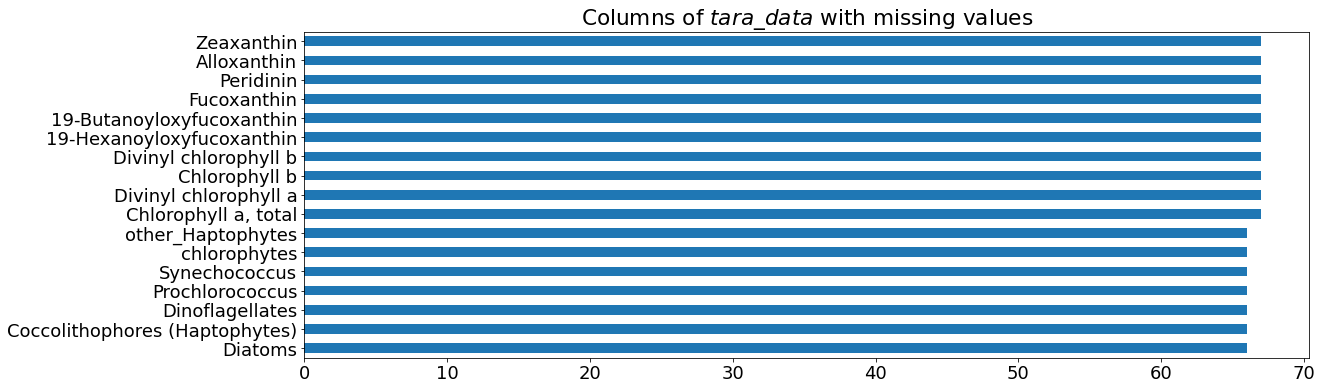

In [15]:
is_column_with_NaN = df_tara_data.isna().sum()
is_column_with_NaN[is_column_with_NaN != 0].plot.barh()
plt.title('Columns of $tara\_data$ with missing values')
plt.show()

In [16]:
pctg_nan = np.reshape(np.array(df_tara_data.isna().sum()/np.shape(df_global_data)[0]*100),(1,17))
np.around(pctg_nan,2)
df_pctgNaN = pd.DataFrame(pctg_nan,columns = columns_taradata, index = ['% de NaN'])
display(df_pctgNaN)

,Diatoms,Coccolithophores (Haptophytes),Dinoflagellates,Prochlorococcus,Synechococcus,chlorophytes,other_Haptophytes,"Chlorophyll a, total",Divinyl chlorophyll a,Chlorophyll b,Divinyl chlorophyll b,19-Hexanoyloxyfucoxanthin,19-Butanoyloxyfucoxanthin,Fucoxanthin,Peridinin,Alloxanthin,Zeaxanthin
% de NaN,0.69591,0.69591,0.69591,0.69591,0.69591,0.69591,0.69591,0.70645,0.70645,0.70645,0.70645,0.70645,0.70645,0.70645,0.70645,0.70645,0.70645


# **Etude bi-dimensionnelle**

## 1 Données brut

### a) Corrélations des datas global

In [17]:
df_global_data.corr()

,"Chlorophyll a, total",Divinyl chlorophyll a,Chlorophyll b,Divinyl chlorophyll b,19-Hexanoyloxyfucoxanthin,19-Butanoyloxyfucoxanthin,Fucoxanthin,Peridinin,Alloxanthin,Zeaxanthin
"Chlorophyll a, total",1.00000,-0.06194,0.36365,-0.01328,0.09536,0.12494,0.63218,0.46702,0.31446,0.12861
Divinyl chlorophyll a,-0.06194,1.00000,-0.06417,0.20846,-0.03670,-0.02062,-0.08937,-0.04830,-0.10159,0.27040
Chlorophyll b,0.36365,-0.06417,1.00000,-0.02682,0.03800,0.03127,0.13016,0.30308,0.14270,0.20323
Divinyl chlorophyll b,-0.01328,0.20846,-0.02682,1.00000,0.11675,0.22185,0.00611,-0.01508,-0.00377,0.01133
19-Hexanoyloxyfucoxanthin,0.09536,-0.03670,0.03800,0.11675,1.00000,0.06753,0.04268,-0.00762,0.13072,-0.02032
19-Butanoyloxyfucoxanthin,0.12494,-0.02062,0.03127,0.22185,0.06753,1.00000,0.21145,0.01390,0.00350,-0.03432
Fucoxanthin,0.63218,-0.08937,0.13016,0.00611,0.04268,0.21145,1.00000,0.15628,0.07138,-0.01184
Peridinin,0.46702,-0.04830,0.30308,-0.01508,-0.00762,0.01390,0.15628,1.00000,0.15346,0.13548
Alloxanthin,0.31446,-0.10159,0.14270,-0.00377,0.13072,0.00350,0.07138,0.15346,1.00000,0.09964
Zeaxanthin,0.12861,0.27040,0.20323,0.01133,-0.02032,-0.03432,-0.01184,0.13548,0.09964,1.00000


In [22]:
base_filename = os.getcwd()+'/Images'
base_filename

'/Users/roberthajjar/Documents/TRIED /Etude_de_cas/Etude_de_cas_TRIED/Images'

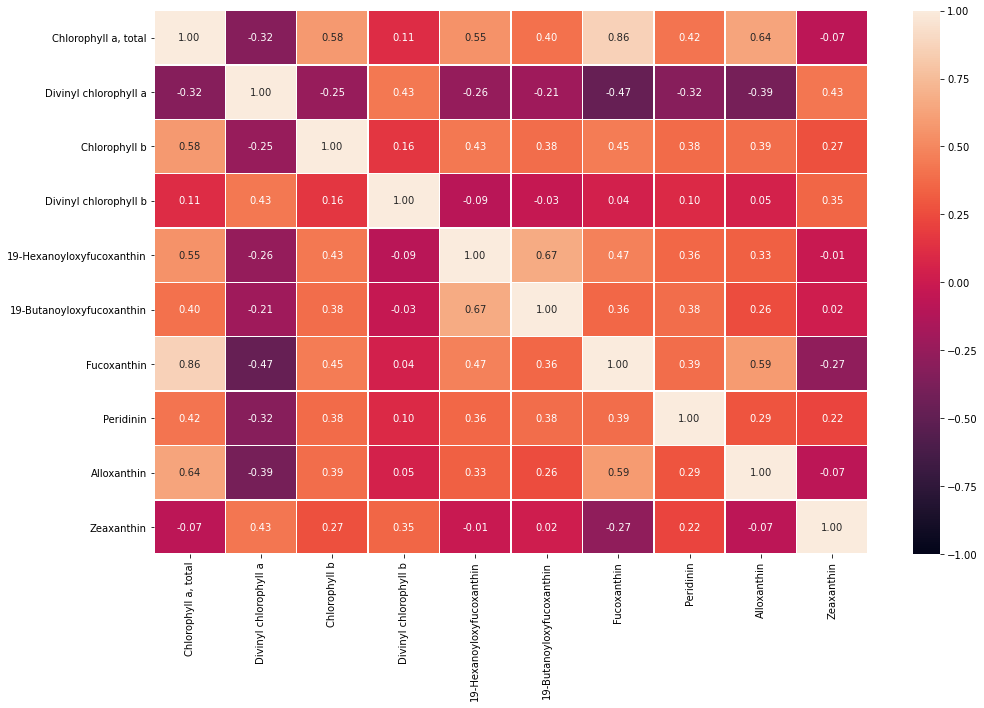

In [64]:
fig = plt.figure(figsize=(16,10))
base_filename = os.getcwd()+'/Images'
ax = sns.heatmap(df_global_data.corr(method='spearman'), annot=True, fmt=".2f", linewidths=.5, vmin=-1, vmax=1)
#
filename_png = base_filename +"_correlations_data_global.png"
plt.savefig(filename_png, dpi=300)

<Figure size 1152x720 with 0 Axes>

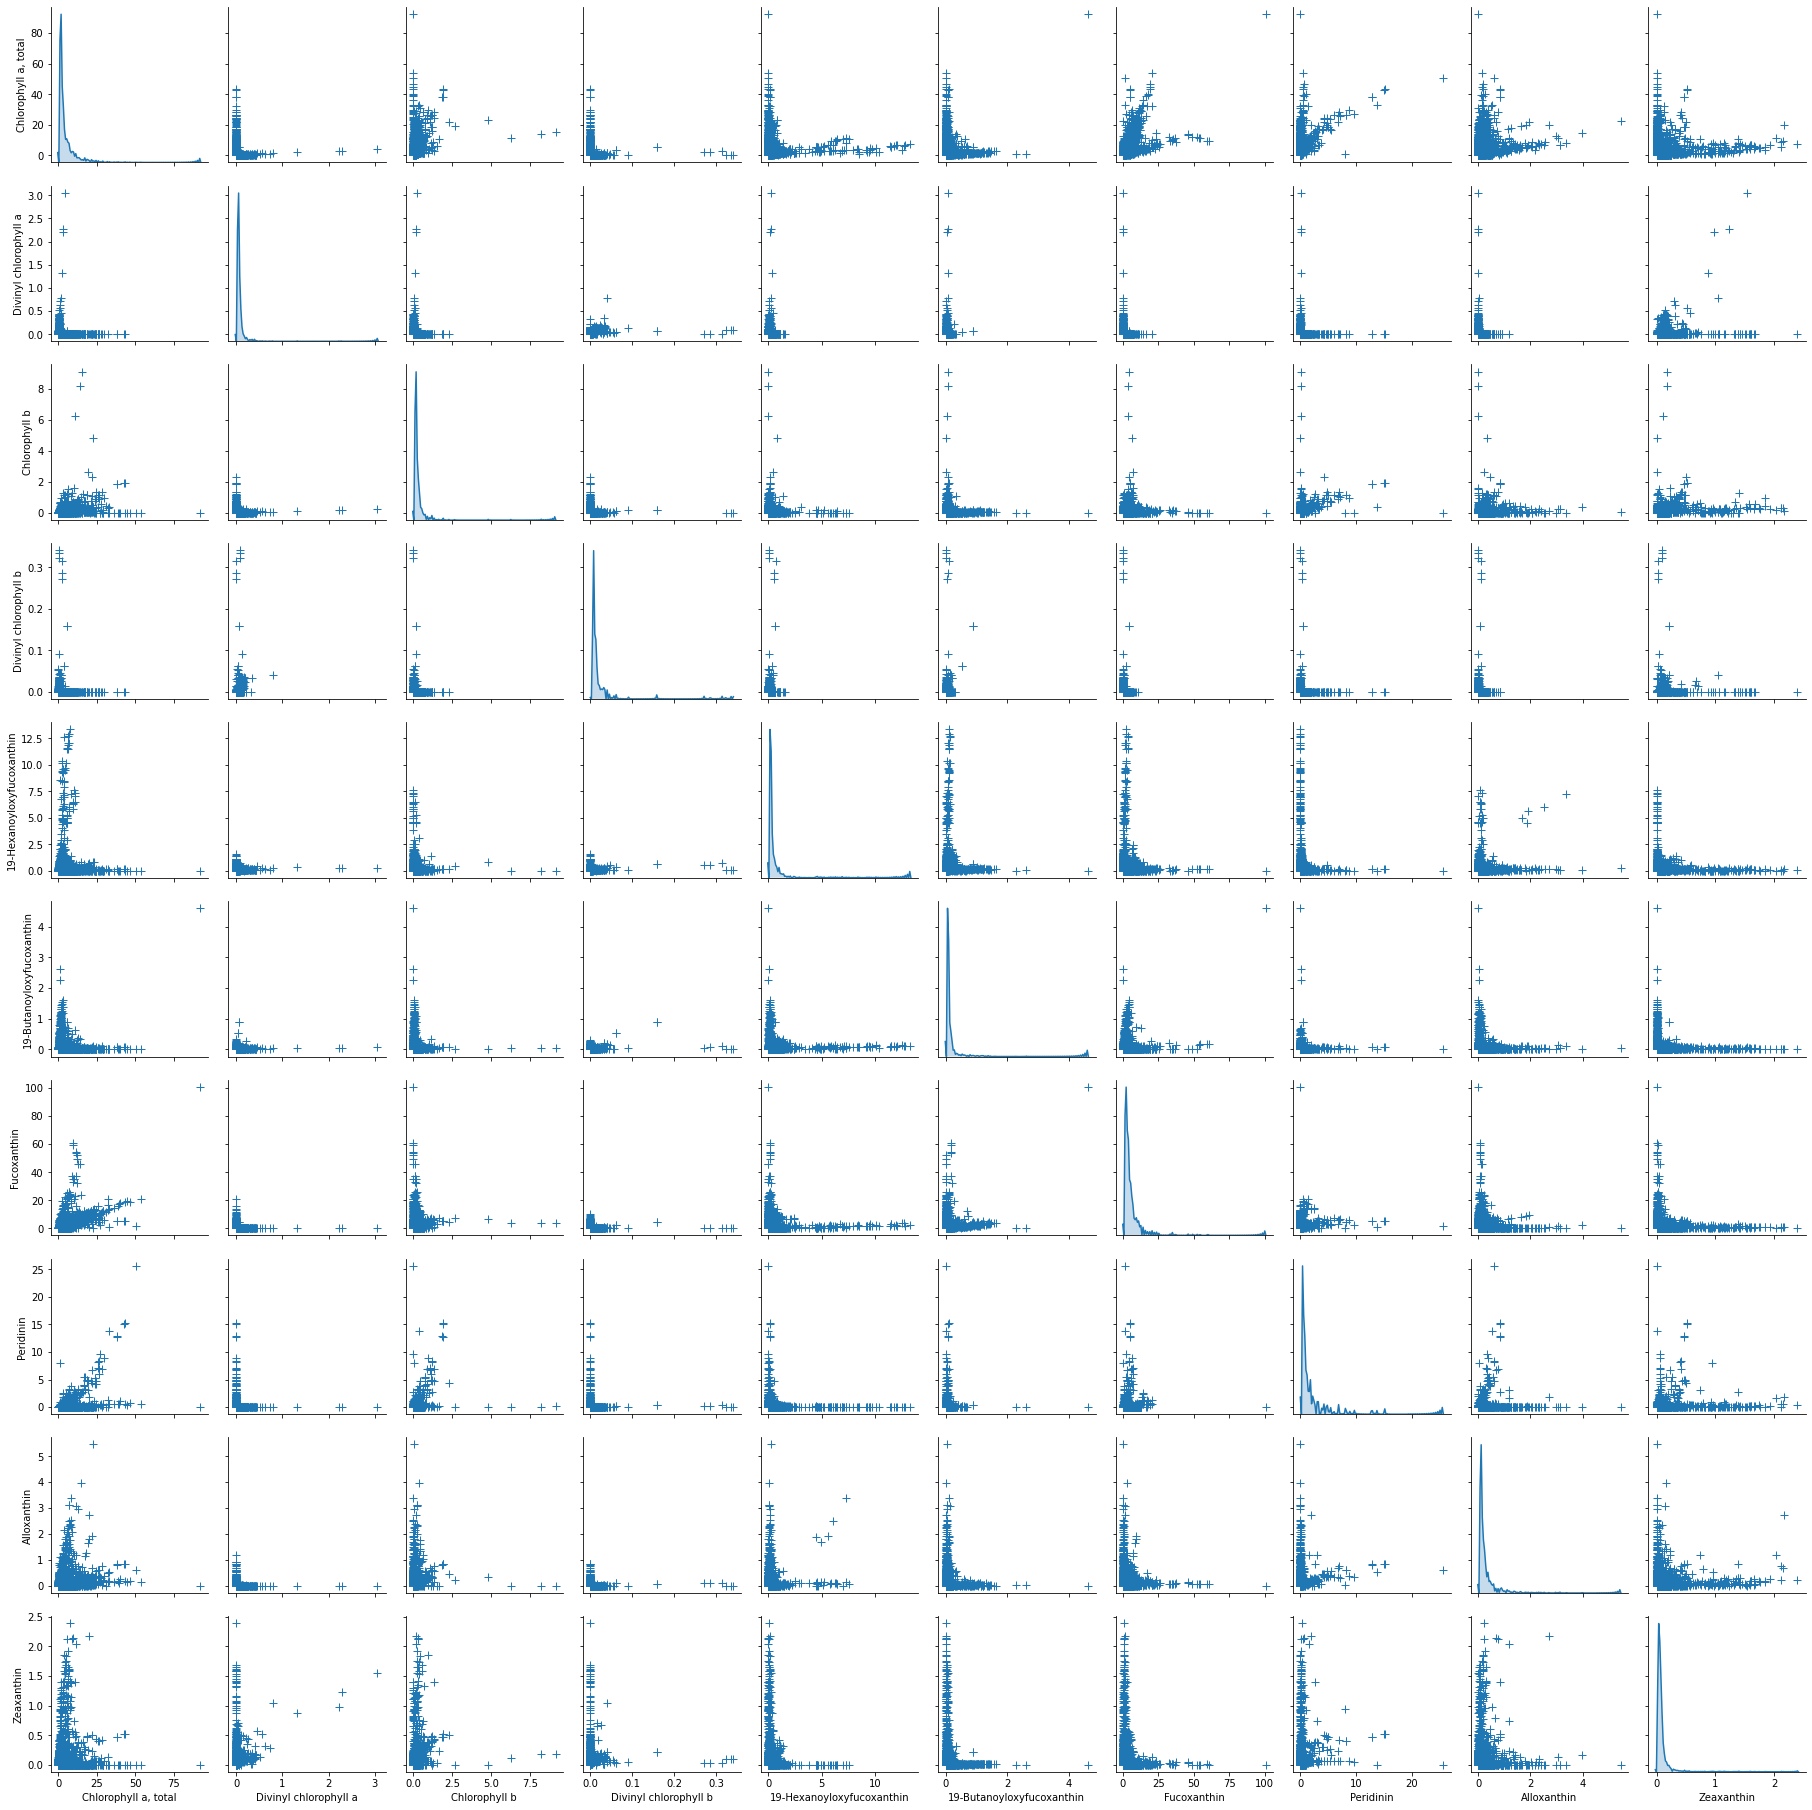

In [44]:
fig = plt.figure(figsize=(16,10))
g = sns.pairplot(df_global_data, diag_kind="kde", markers="+",
                  plot_kws=dict(s=50, edgecolor="b", linewidth=1),
                  diag_kws=dict(shade=True))

### b) Corrélations des datas tara

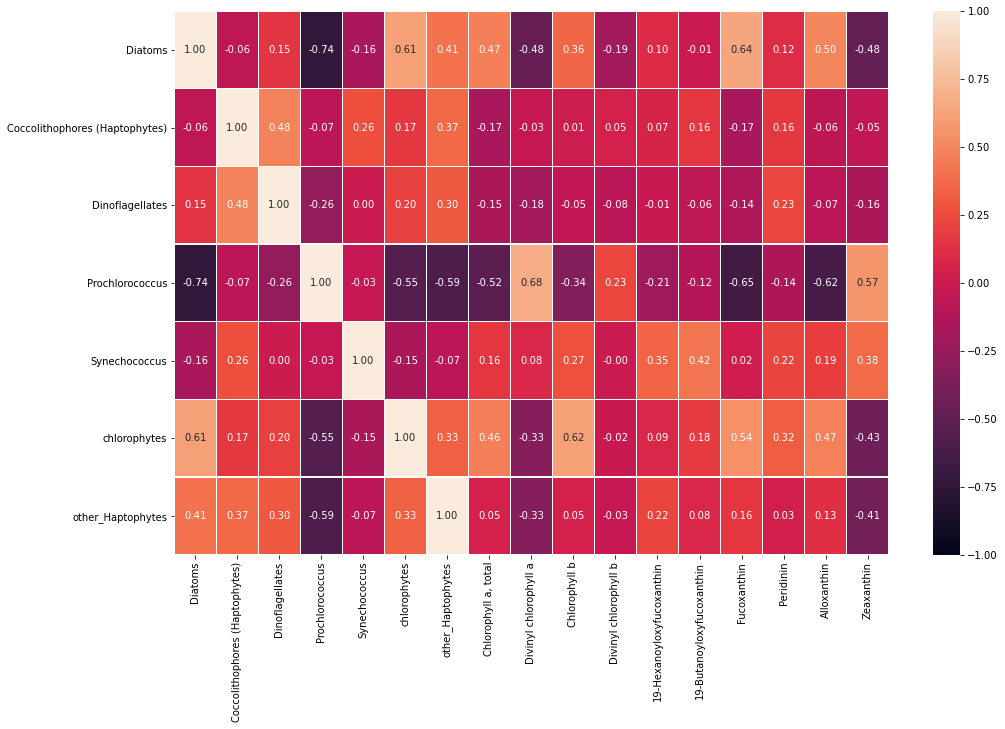

In [65]:
fig = plt.figure(figsize=(16,10))
base_filename = os.getcwd()+'/Images'
ax = sns.heatmap(df_tara_data.corr(method='spearman').iloc[:7,:], annot=True, fmt=".2f", linewidths=.5, vmin=-1, vmax=1)
#
filename_png = base_filename +"_correlations_tara.png"
plt.savefig(filename_png, dpi=300)

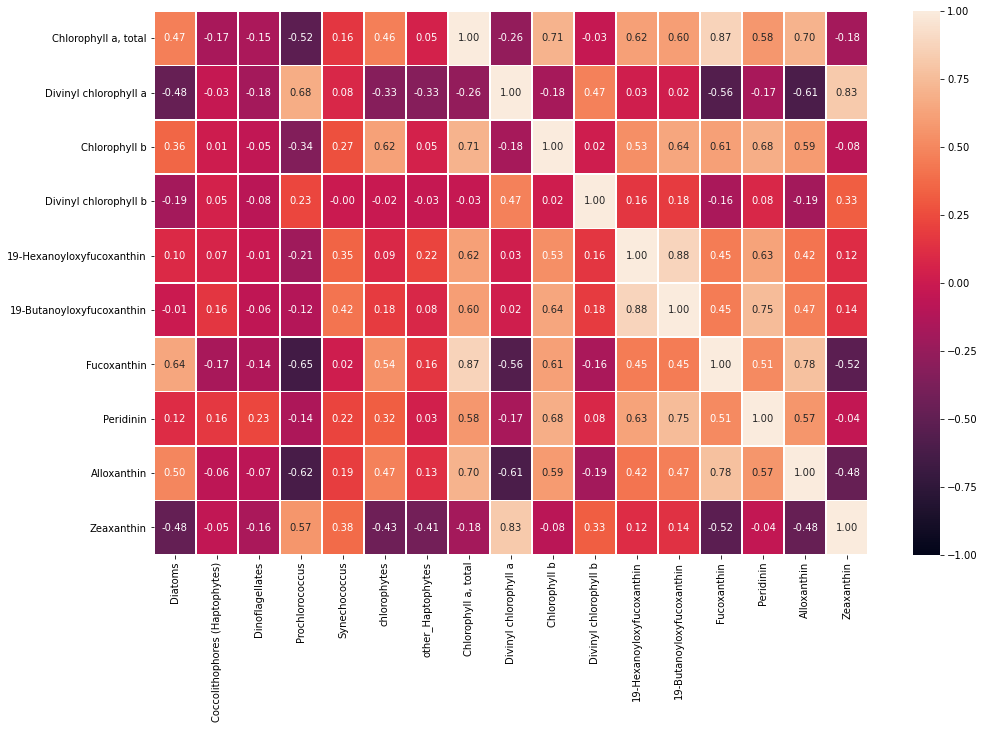

In [66]:
fig = plt.figure(figsize=(16,10))
base_filename = os.getcwd()+'/Images'
ax = sns.heatmap(df_tara_data.corr(method='spearman').iloc[7:,:], annot=True, fmt=".2f", linewidths=.5, vmin=-1, vmax=1)
#
filename_png = base_filename +"_correlations_tara.png"
plt.savefig(filename_png, dpi=300)

/Users/roberthajjar/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


<Figure size 1152x720 with 0 Axes>

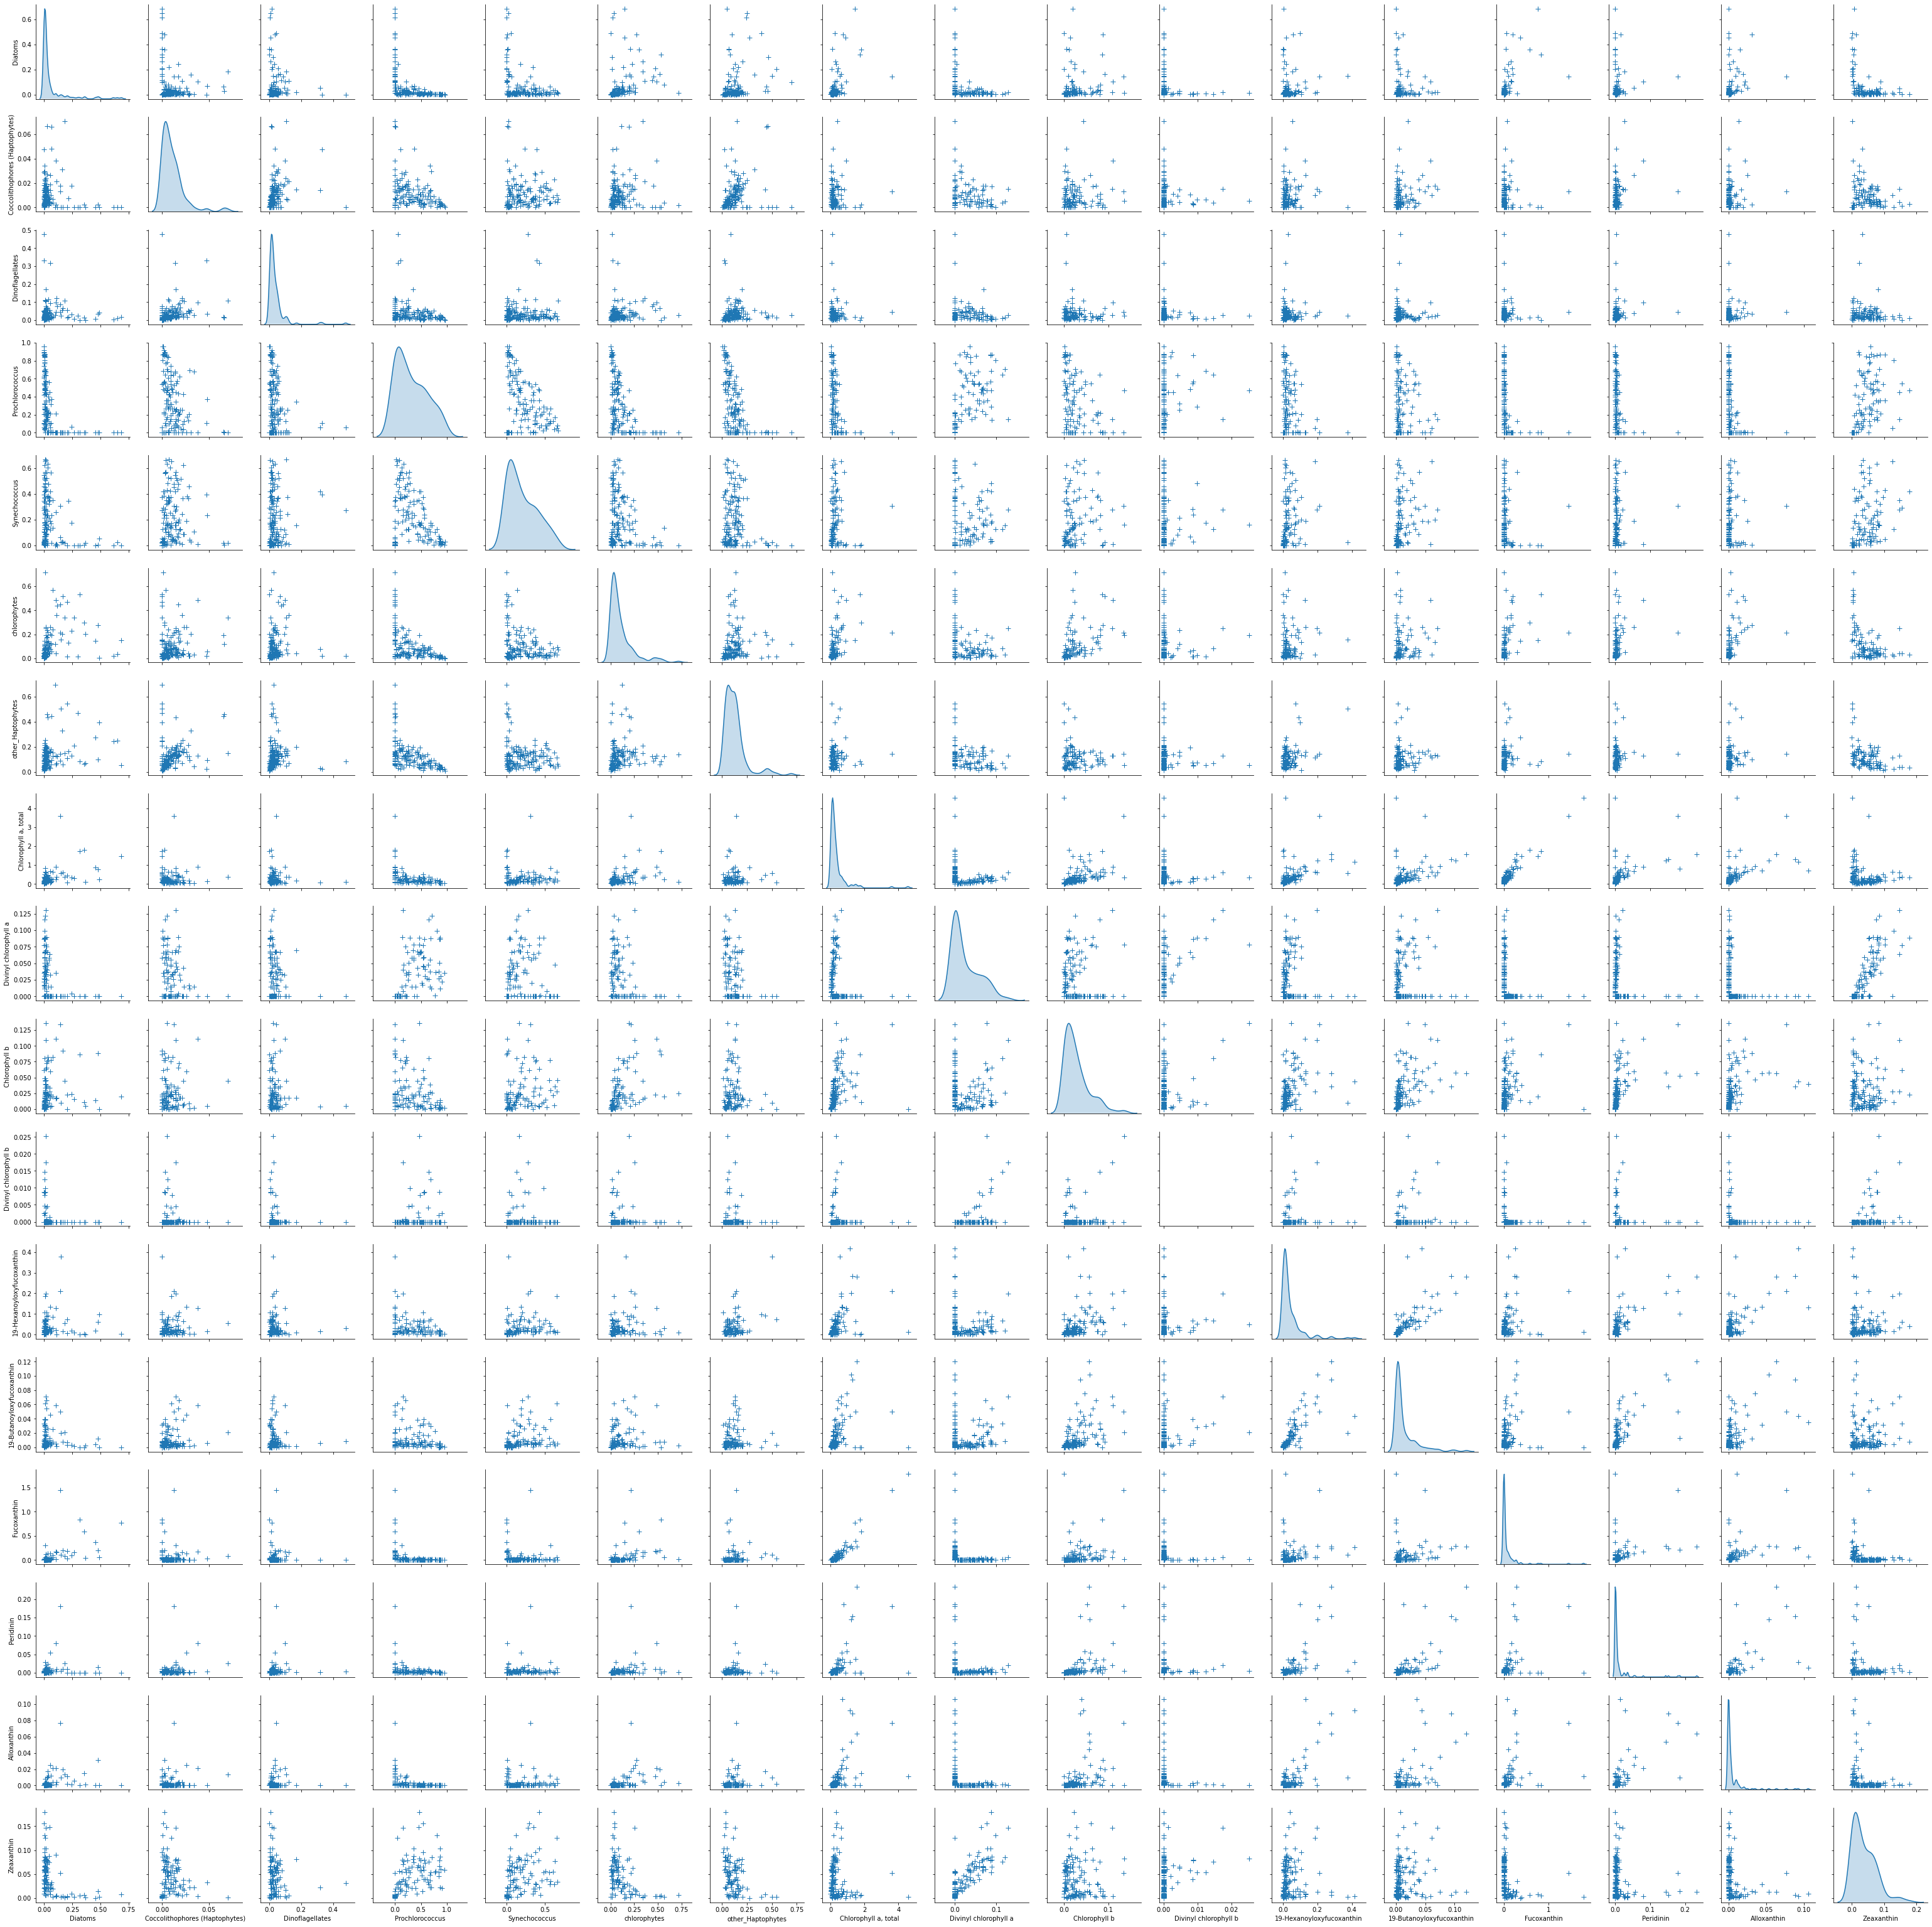

In [45]:
fig = plt.figure(figsize=(16,10))
g = sns.pairplot(df_tara_data, diag_kind="kde", markers="+",
                  plot_kws=dict(s=50, edgecolor="b", linewidth=1),
                  diag_kws=dict(shade=True))

### 2 Données transformer (ln(1+X))

In [62]:
df_ln_global = np.log(df_global_data + 1)
df_ln_global.head()

,"Chlorophyll a, total",Divinyl chlorophyll a,Chlorophyll b,Divinyl chlorophyll b,19-Hexanoyloxyfucoxanthin,19-Butanoyloxyfucoxanthin,Fucoxanthin,Peridinin,Alloxanthin,Zeaxanthin
0,0.39339,0.05354,0.05733,NaN,0.08158,0.01587,0.02859,0.01686,0.00698,0.17227
1,0.81004,0.00000,0.24451,NaN,0.22154,0.05921,0.28668,0.06204,0.10075,0.03826
2,0.92307,0.00000,0.18731,NaN,0.21026,0.06297,0.49225,0.05449,0.18814,0.02956
3,1.47316,0.00000,0.00000,NaN,0.12839,0.03440,1.11743,0.08158,0.00000,0.04688
4,0.84372,0.00000,0.17563,NaN,0.25309,0.05164,0.28968,0.14150,0.03150,0.16042


In [63]:
df_ln_tara = np.log(df_tara_data + 1)
df_ln_tara.head()

,Diatoms,Coccolithophores (Haptophytes),Dinoflagellates,Prochlorococcus,Synechococcus,chlorophytes,other_Haptophytes,"Chlorophyll a, total",Divinyl chlorophyll a,Chlorophyll b,Divinyl chlorophyll b,19-Hexanoyloxyfucoxanthin,19-Butanoyloxyfucoxanthin,Fucoxanthin,Peridinin,Alloxanthin,Zeaxanthin
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.00377,0.01400,0.02305,0.51927,0.14602,0.03329,0.03514,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.01384,0.01664,0.03086,0.17649,0.36334,0.04597,0.12019,0.35077,0.00126,0.03269,0.0,0.02501,0.00387,0.11457,0.0,0.00154,0.00694


### a) Corrélations ln_global

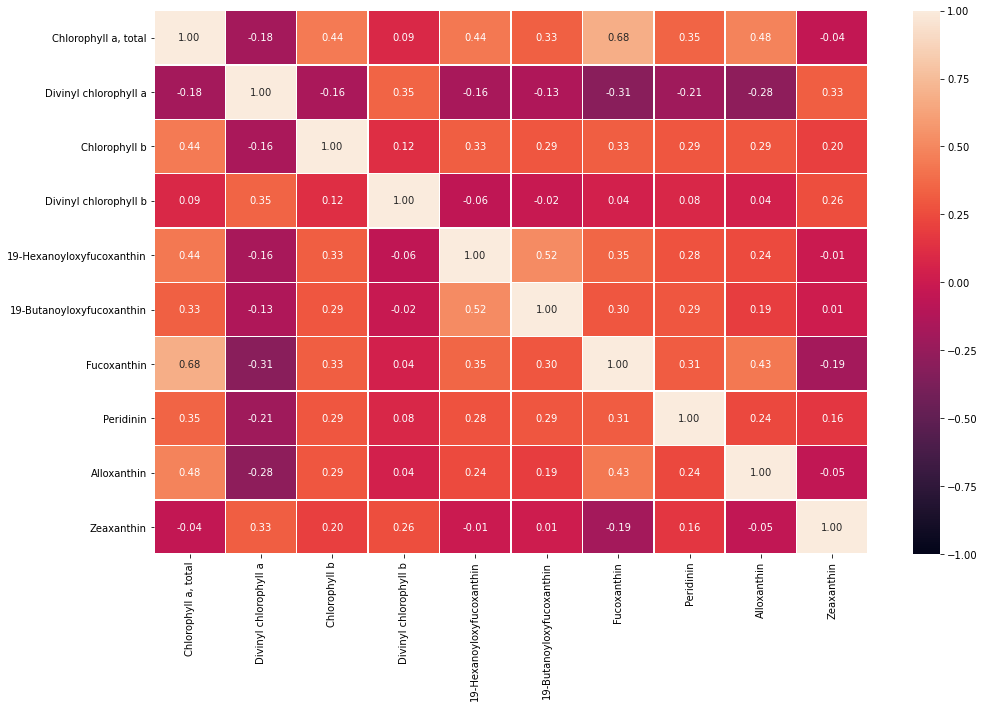

In [68]:
fig = plt.figure(figsize=(16,10))
base_filename = os.getcwd()+'/Images'
ax = sns.heatmap(df_ln_global.corr(method='kendall'), annot=True, fmt=".2f", linewidths=.5, vmin=-1, vmax=1)
#
filename_png = base_filename +"_correlations_ln_data_global.png"
plt.savefig(filename_png, dpi=300)

/Users/roberthajjar/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


<Figure size 1152x720 with 0 Axes>

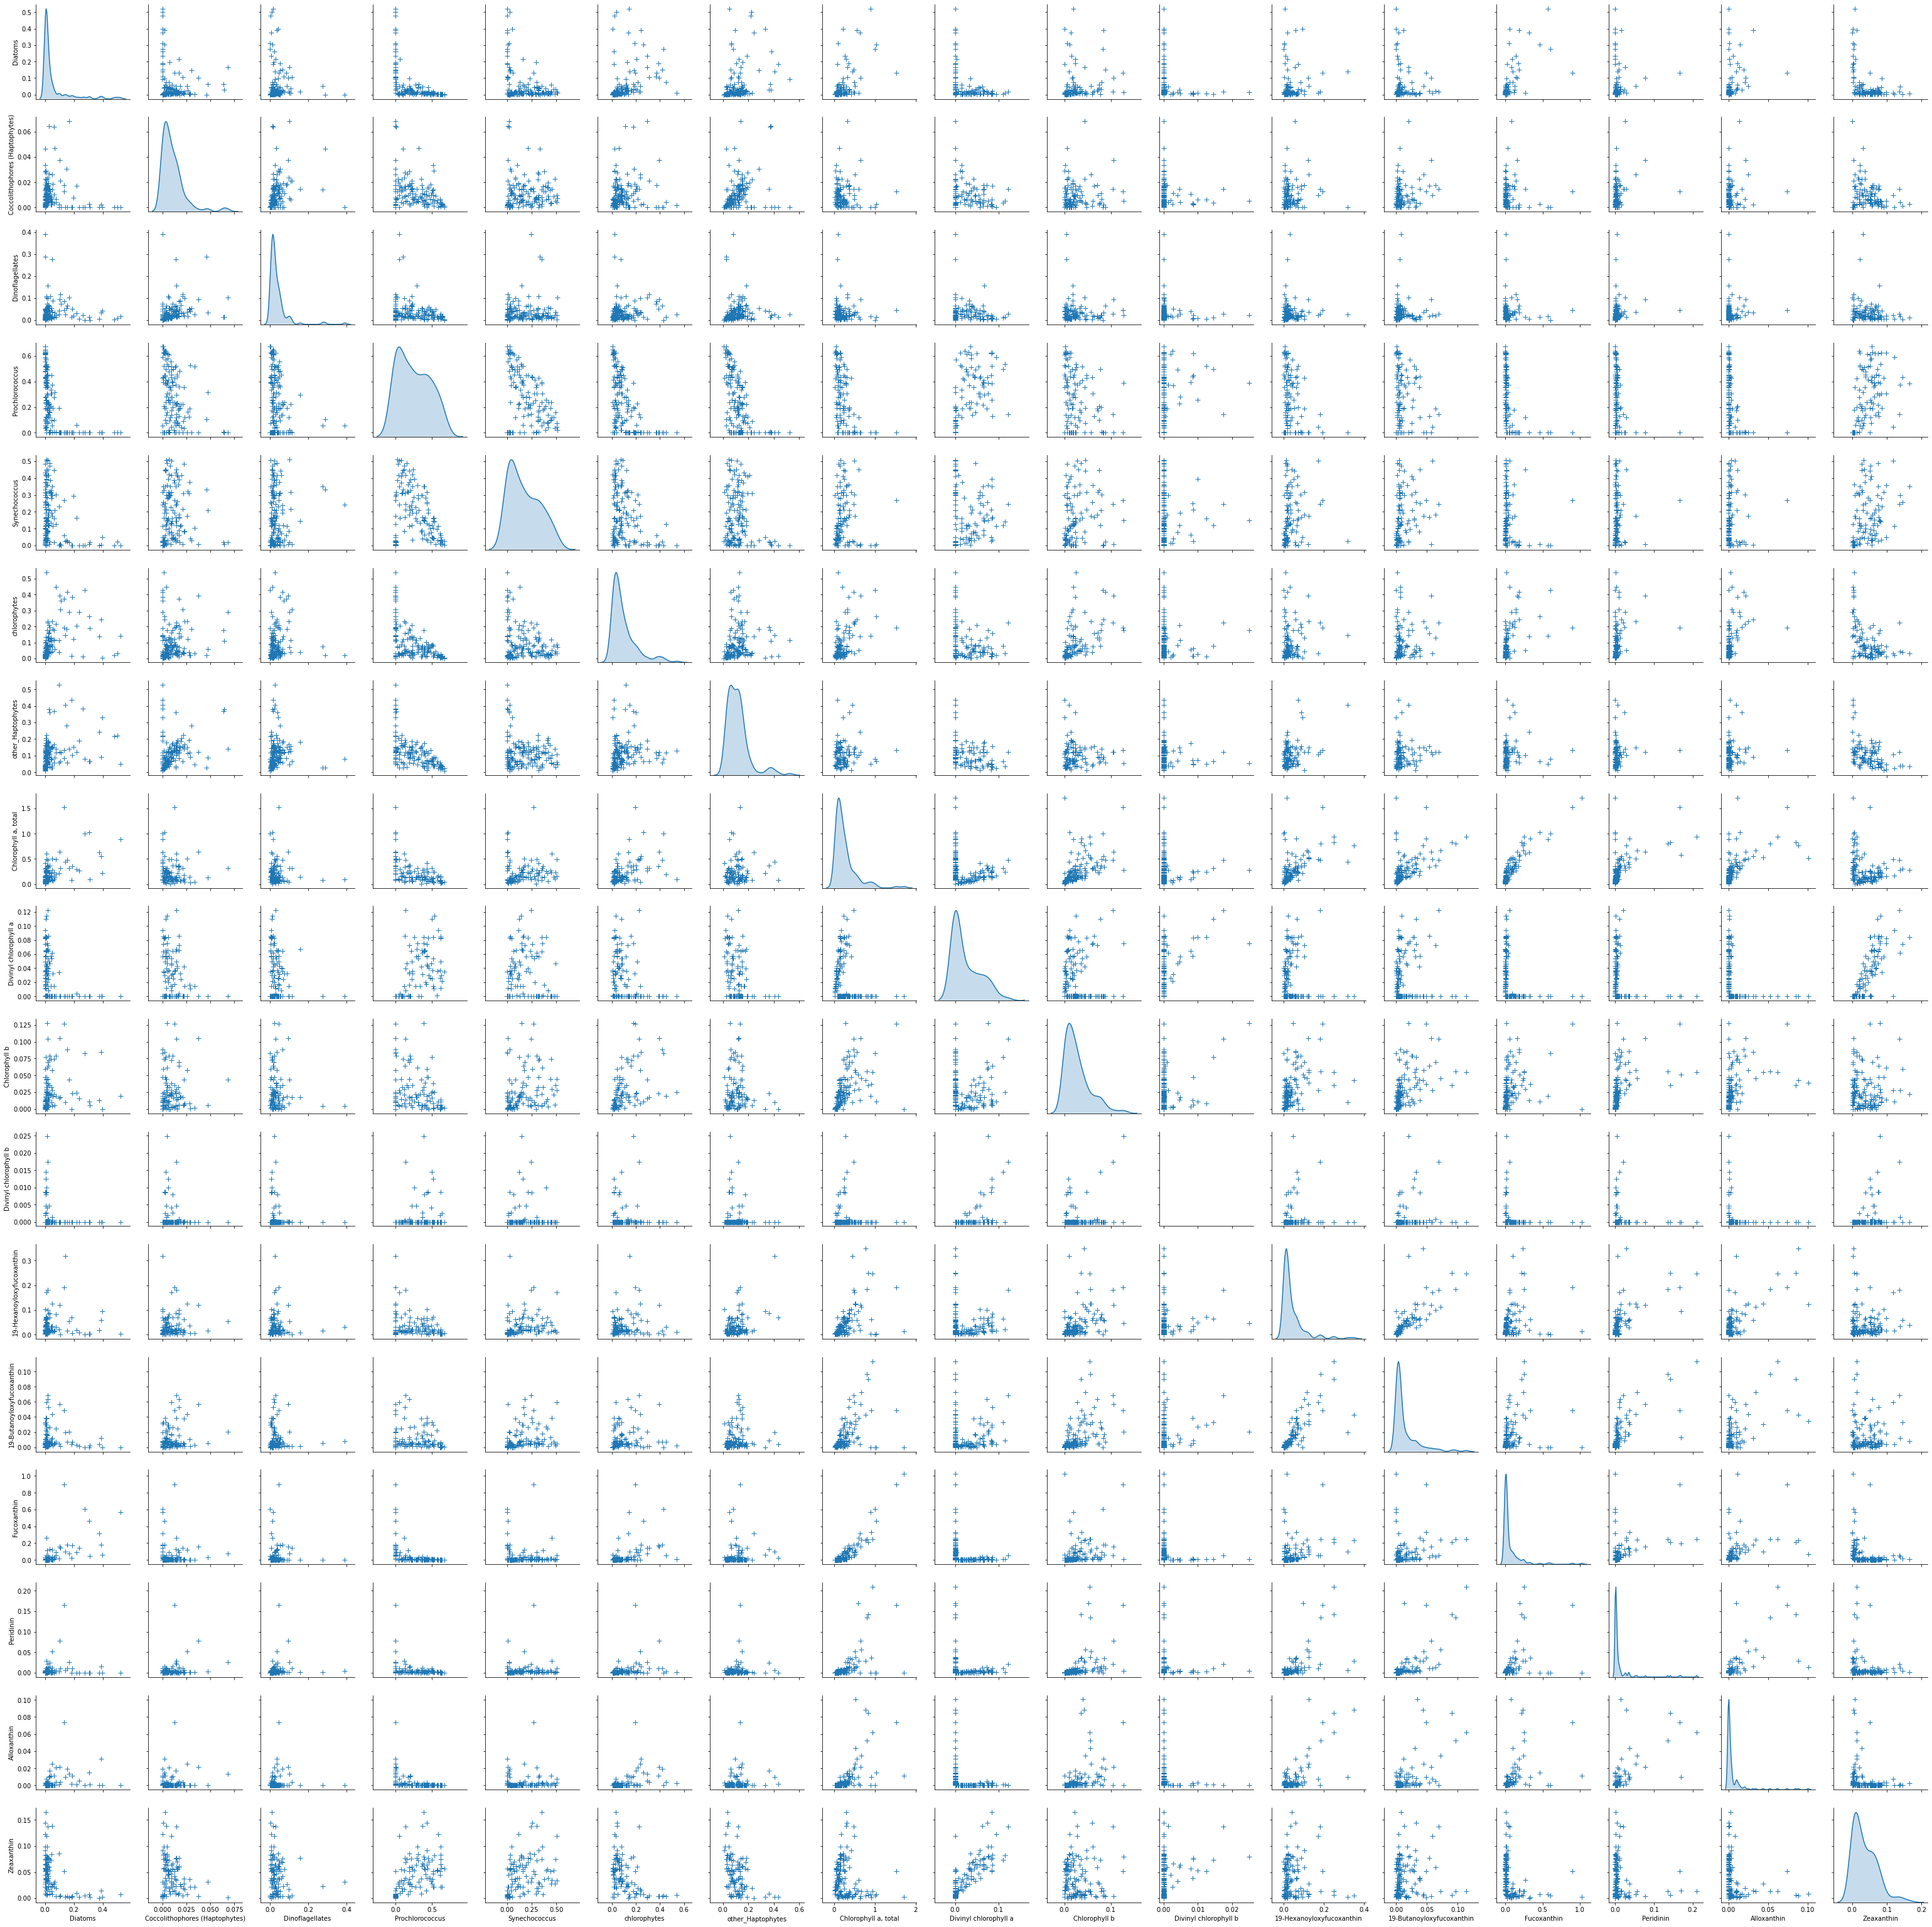

In [57]:
fig = plt.figure(figsize=(16,10))
g = sns.pairplot(df_ln_tara, diag_kind="kde", markers="+",
                  plot_kws=dict(s=50, edgecolor="b", linewidth=1),
                  diag_kws=dict(shade=True))

### b) Corrélations ln_tara

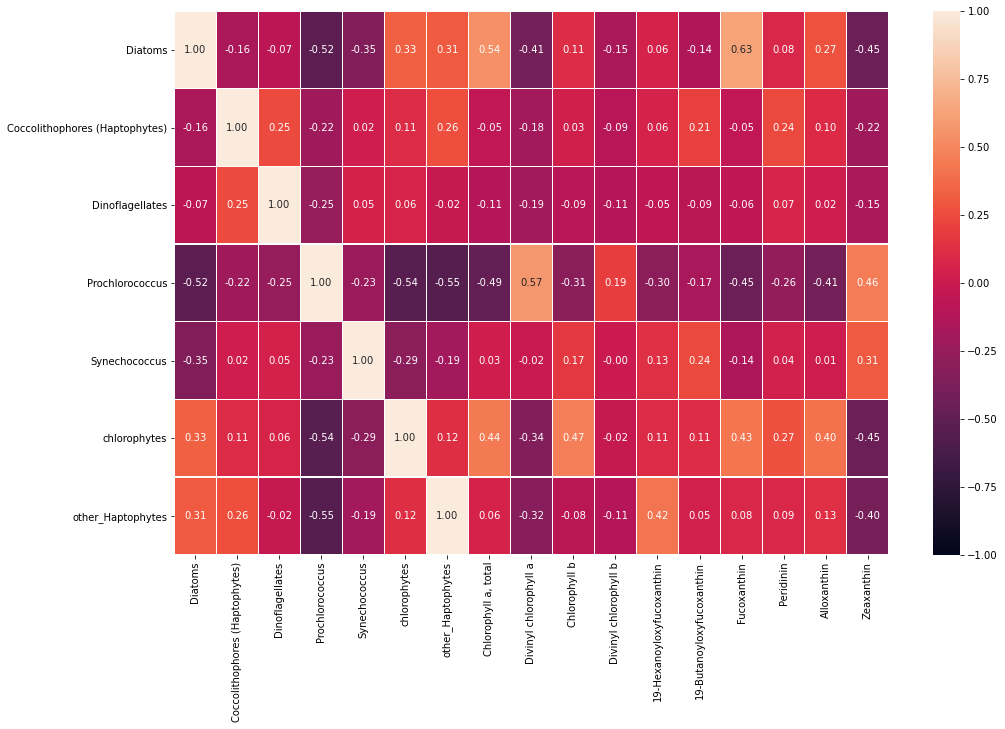

In [58]:
fig = plt.figure(figsize=(16,10))
base_filename = os.getcwd()+'/Images'
ax = sns.heatmap(df_ln_tara.corr().iloc[:7,:], annot=True, fmt=".2f", linewidths=.5, vmin=-1, vmax=1)
#
filename_png = base_filename +"_correlations_tara.png"
plt.savefig(filename_png, dpi=300)

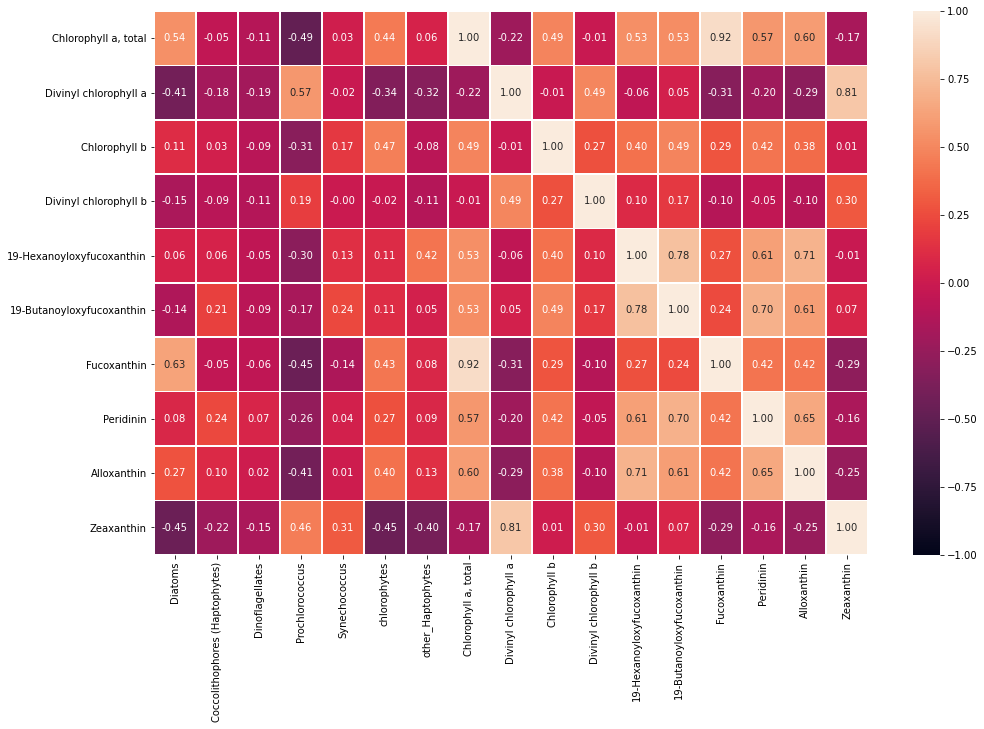

In [59]:
fig = plt.figure(figsize=(16,10))
base_filename = os.getcwd()+'/Images'
ax = sns.heatmap(df_ln_tara.corr().iloc[7:,:], annot=True, fmt=".2f", linewidths=.5, vmin=-1, vmax=1)
#
filename_png = base_filename +"_correlations_tara.png"
plt.savefig(filename_png, dpi=300)

/Users/roberthajjar/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


<Figure size 1152x720 with 0 Axes>

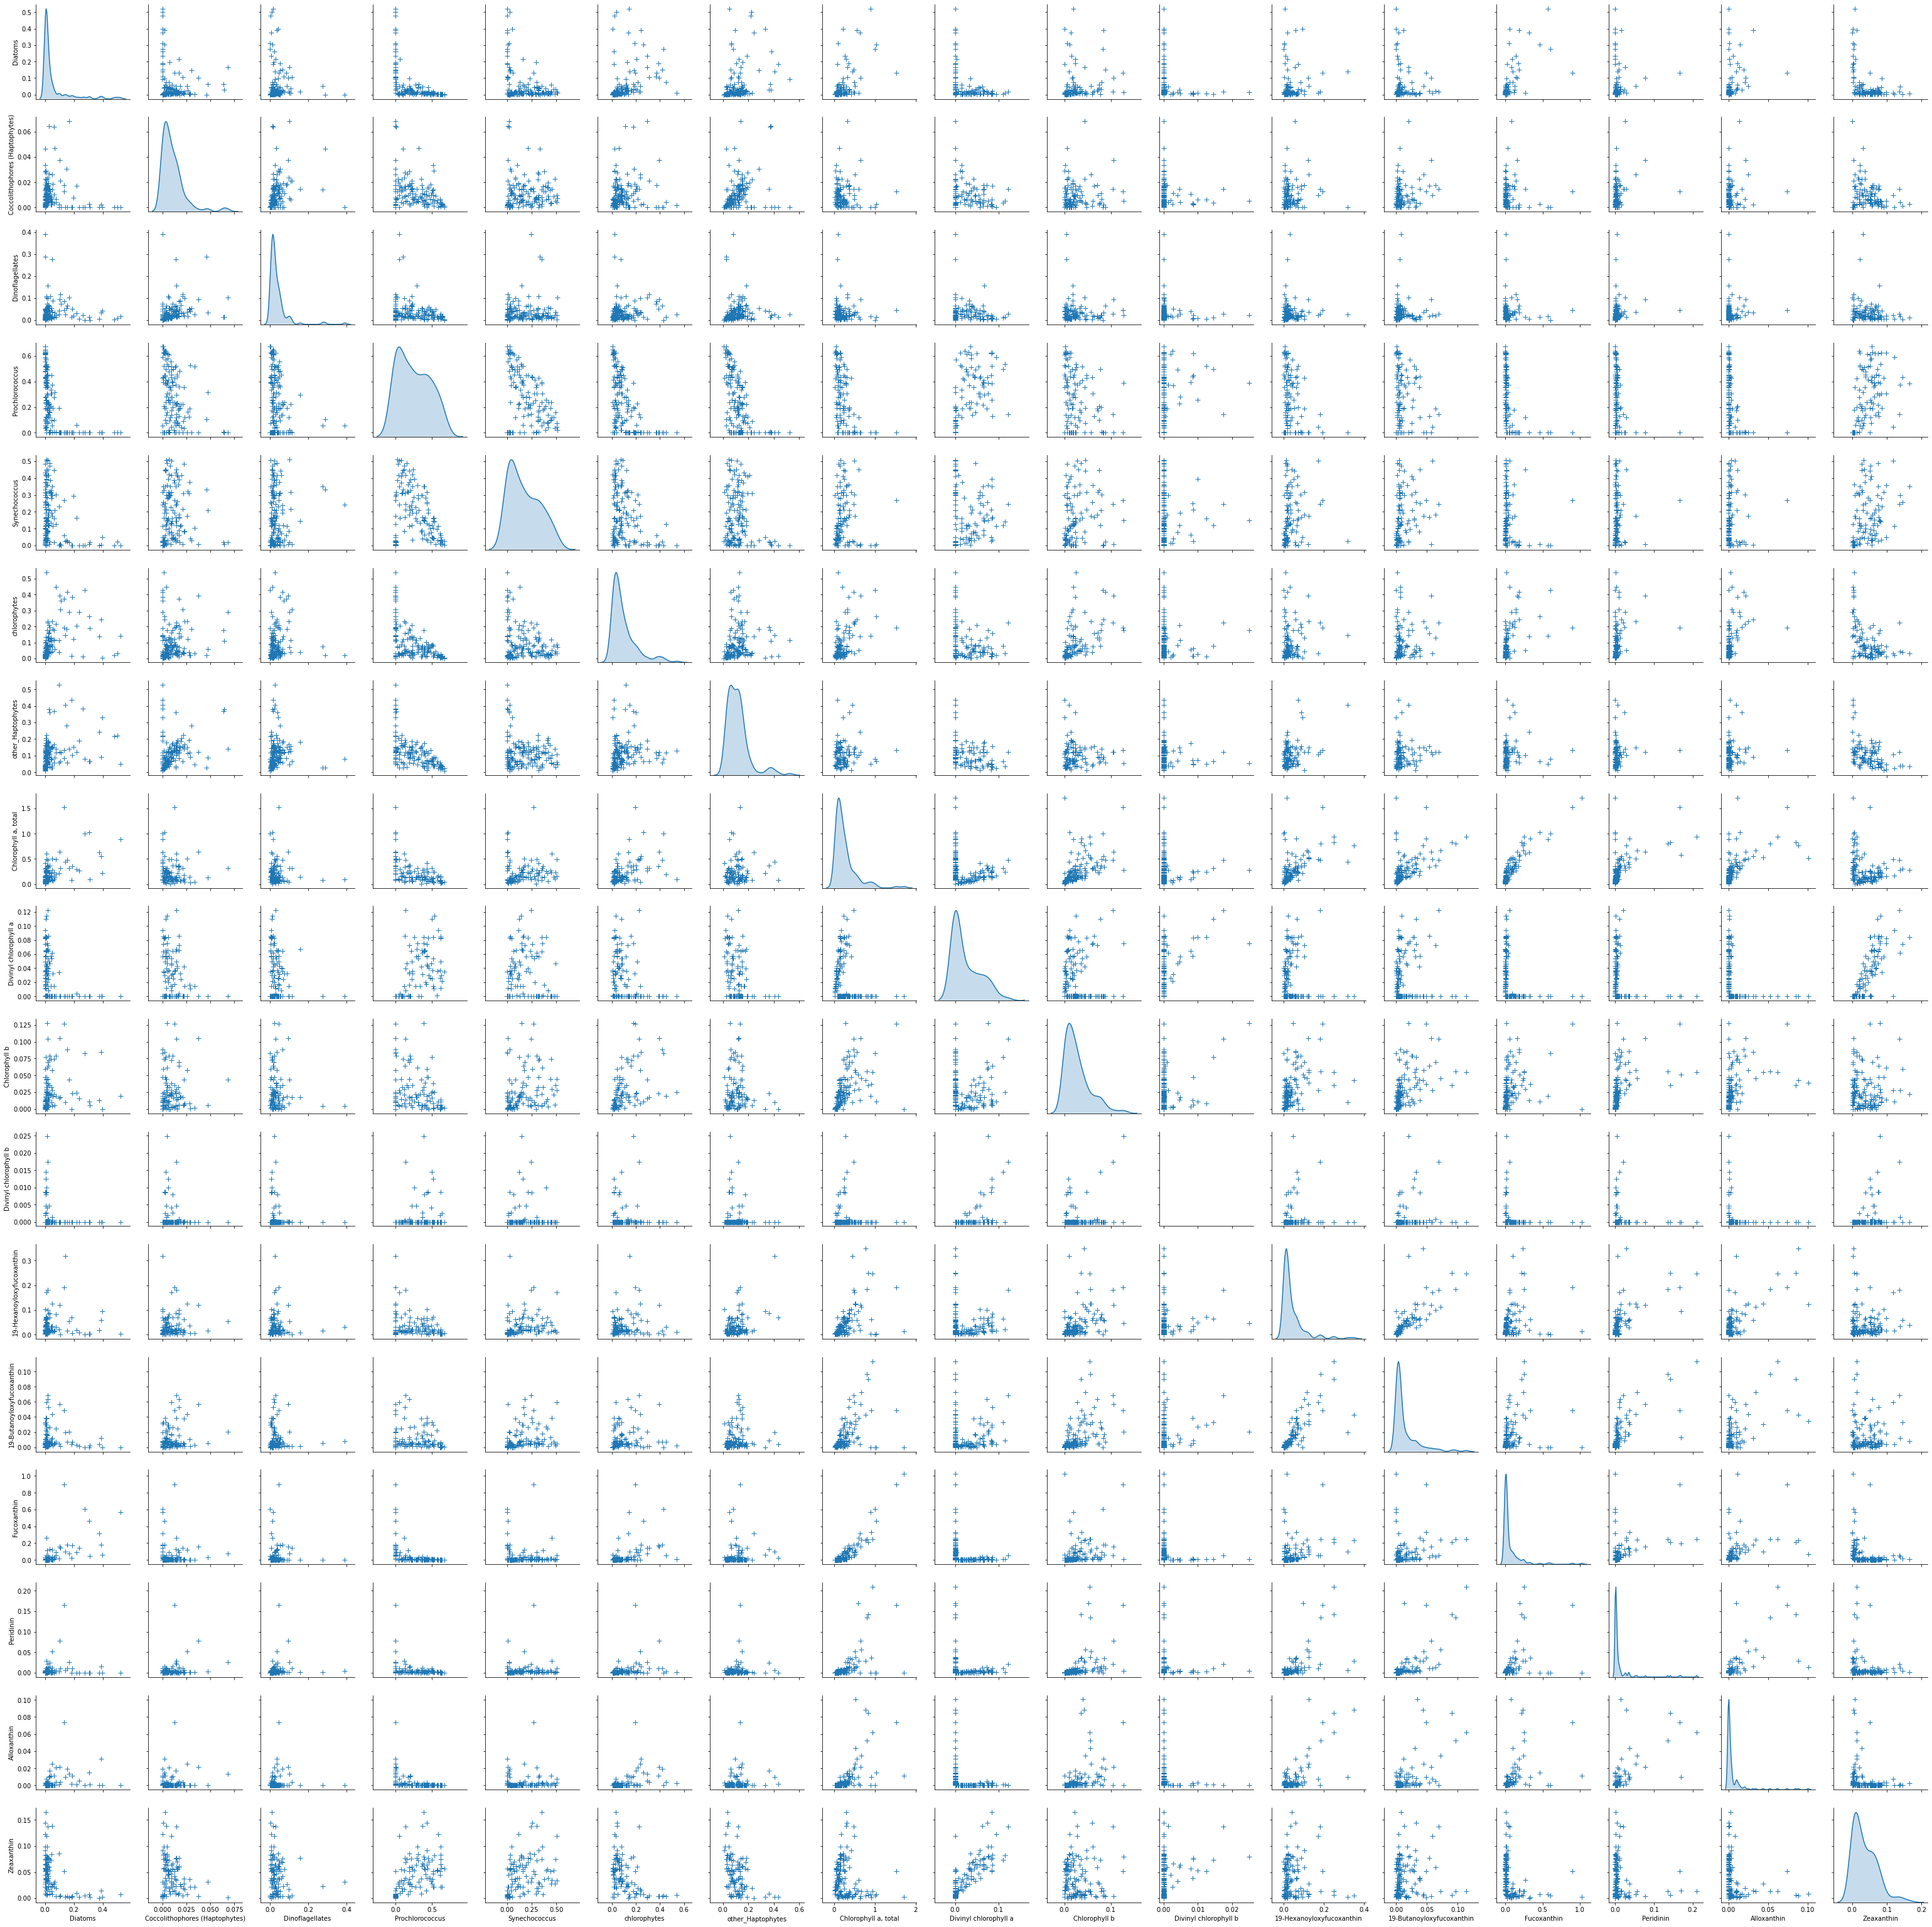

In [60]:
fig = plt.figure(figsize=(16,10))
g = sns.pairplot(df_ln_tara, diag_kind="kde", markers="+",
                  plot_kws=dict(s=50, edgecolor="b", linewidth=1),
                  diag_kws=dict(shade=True))

# ACP